In [ ]:
%%capture
!pip install arch

In [ ]:
# Import dataframe from the cleaned raw csv data file
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

cleaned_raw_data_url = 'https://raw.githubusercontent.com/qkma-umich/milestone2_team18/refs/heads/main/data.csv'
df = pd.read_csv(cleaned_raw_data_url, index_col=0)
df.set_index('Date', inplace=True)
df.head()

,SPY,SPY_log_return,SPY_vol_5d,XLC,XLC_log_return,XLC_vol_5d,XLY,XLY_log_return,XLY_vol_5d,XLP,...,Overnight Rate,1-Month Rate,3-Month Rate,CPI,PPI,Unemployment Rate,GDP,CPI_pct_change,PPI_pct_change,GDP_pct_change
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-11,354.542755,-0.006763,0.019447,63.310917,-0.017940,0.023259,159.420868,-0.018838,0.035987,58.630135,...,0.09,0.08,0.10,262.639,204.8,6.4,22680.693,0.0,0.0,0.0
2021-01-12,354.617584,0.000211,0.018196,62.289005,-0.016273,0.028157,161.855865,0.015159,0.038334,58.435673,...,0.09,0.09,0.09,262.639,204.8,6.4,22680.693,0.0,0.0,0.0
2021-01-13,355.572571,0.002689,0.017402,62.508682,0.003521,0.027966,161.846252,-0.000059,0.036964,58.524059,...,0.09,0.09,0.10,262.639,204.8,6.4,22680.693,0.0,0.0,0.0
2021-01-14,354.327332,-0.003508,0.009879,62.155300,-0.005669,0.025316,160.816376,-0.006384,0.032279,58.214691,...,0.09,0.09,0.09,262.639,204.8,6.4,22680.693,0.0,0.0,0.0
2021-01-15,351.743347,-0.007319,0.010904,62.355869,0.003222,0.025329,159.574829,-0.007750,0.026182,58.011387,...,0.09,0.09,0.10,262.639,204.8,6.4,22680.693,0.0,0.0,0.0


In [ ]:
# Selected feature names of external variables
feature_names = ['VIX', 'VIX_log', 'Overnight Rate', '1-Month Rate', '3-Month Rate', 'Unemployment Rate', 'CPI_pct_change', 'PPI_pct_change', 'GDP_pct_change']
X = df[feature_names]
y = df["SPY_vol_5d"]


# Split the data into training and testing sets, set shuffle to false due to time series data
train_test_split_test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_test_size, random_state=42, shuffle=False)


In [ ]:
# Ranking Feature Correlation
feature_correlations = []
for name in feature_names:
    result = np.corrcoef(df['SPY_vol_5d'], df[name])[0][1]
    feature_correlations.append(result)

print("Feature correlation ranked from high to low")
df_feature_correlations = pd.DataFrame({'Feature': feature_names, 'Correlation_with_SPY_vol_5d': feature_correlations}).sort_values(by='Correlation_with_SPY_vol_5d', ascending=False).reset_index(drop=True)
df_feature_correlations

Feature correlation ranked from high to low


,Feature,Correlation_with_SPY_vol_5d
0,VIX,0.728244
1,CPI_pct_change,0.173100
2,GDP_pct_change,0.069981
3,PPI_pct_change,0.022299
4,VIX_log,-0.046392
5,3-Month Rate,-0.065291
6,1-Month Rate,-0.105819
7,Overnight Rate,-0.139574
8,Unemployment Rate,-0.193069


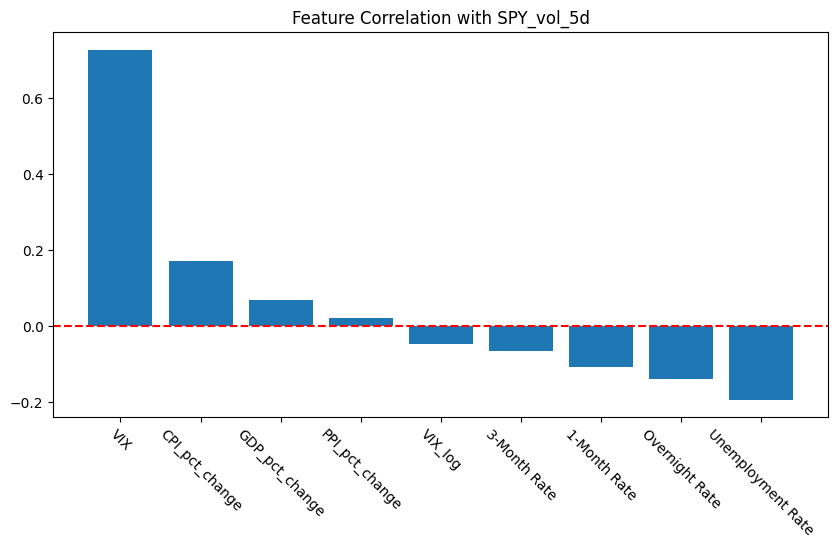

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(df_feature_correlations['Feature'], df_feature_correlations['Correlation_with_SPY_vol_5d'])
plt.axhline(0, color='red', linestyle='--')
plt.title("Feature Correlation with SPY_vol_5d")
plt.xticks(rotation=-45)
plt.show()

Simple Linear Regression Model

In [ ]:
# Simple Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Linear Regression Model R^2 Score: ", lr_model.score(X_test, y_test))
lr_model_predictions = lr_model.predict(X_test)
lr_model_mse = mean_squared_error(y_test, lr_model_predictions)
print("RMSE of Linear Model Predictions: ", lr_model_mse)

Linear Regression Model R^2 Score:  0.5334724528016369
RMSE of Linear Model Predictions:  0.00015106446882742246


In [ ]:
# Time Series Cross Validation
r2_scores_lr = []
rmse_scores_lr = []
mae_scores_lr = []
lr_tests_dict = {}
lr_y_preds_dict = {}

tscv = TimeSeriesSplit(n_splits=5)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr_model.fit(X_train, y_train)
    lr_model_y_pred = lr_model.predict(X_test)
    lr_y_preds_dict[i] = lr_model_y_pred
    lr_tests_dict[i] = y_test

    r2_scores_lr.append(lr_model.score(X_train, y_train))
    mae_scores_lr.append(mean_absolute_error(y_test, lr_model_y_pred))
    rmse_scores_lr.append(root_mean_squared_error(y_test, lr_model_y_pred))

print("R^2\n", r2_scores_lr)
print("MAE\n", mae_scores_lr)
print("RMSE\n", rmse_scores_lr)

print("\nMean Values: \nR^2",  np.mean(r2_scores_lr), "\nMAE", np.mean(mae_scores_lr), "\nRMSE", np.mean(rmse_scores_lr))

R^2
 [0.49633736995937017, 0.7328643344299238, 0.6247392620835931, 0.636898323037276, 0.6241047190116344]
MAE
 [0.028869149535576285, 0.007029257982415689, 0.003979210100061045, 0.00463214875890057, 0.006971754260687101]
RMSE
 [0.04111682184850057, 0.009238374523436602, 0.005173013728457431, 0.005973217951182018, 0.013254412596091695]

Mean Values: 
R^2 0.6229888017043596 
MAE 0.010296304127528138 
RMSE 0.014951168129533662


GARCH(1,1) Model, as GARCH is a better model for stock time series data to predict stock volatility

Compare the results of the lag parameter of 0 (defualt) and 1 for sensativity analysis

In [ ]:
# Multiply y by 100 due to small target variable not performing well with garch models
y_x100 = df["SPY_vol_5d"]*100

# GARCH wihout lag to compare performance
garch = arch_model(y_x100, mean='ARX', vol='Garch', p=1, q=1, lags=0, rescale=False)

garch_model = garch.fit(disp='off')
print(garch_model.summary())

                           AR - GARCH Model Results                           
Dep. Variable:             SPY_vol_5d   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1407.07
Distribution:                  Normal   AIC:                           2822.15
Method:            Maximum Likelihood   BIC:                           2842.59
                                        No. Observations:                 1226
Date:                Mon, Oct 20 2025   Df Residuals:                     1225
Time:                        20:47:05   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          1.6103  5.203e-02     30.951 2.491e-210 [  1.508,  1.71

In [ ]:
# GARCH with lag=1
garch = arch_model(y_x100, mean='ARX', vol='Garch', p=1, q=1, lags=1, rescale=False)

garch_model = garch.fit(disp='off')
print(garch_model.summary())

                           AR - GARCH Model Results                           
Dep. Variable:             SPY_vol_5d   R-squared:                       0.823
Mean Model:                        AR   Adj. R-squared:                  0.823
Vol Model:                      GARCH   Log-Likelihood:               -781.644
Distribution:                  Normal   AIC:                           1573.29
Method:            Maximum Likelihood   BIC:                           1598.84
                                        No. Observations:                 1225
Date:                Mon, Oct 20 2025   Df Residuals:                     1223
Time:                        20:47:05   Df Model:                            2
                                 Mean Model                                
                    coef    std err          t      P>|t|  95.0% Conf. Int.
---------------------------------------------------------------------------
Const             0.2085  3.561e-02      5.856  4.753e-09 [  

In [ ]:
# Time Series Cross Validation for GARCH MODELS
tscv = TimeSeriesSplit(n_splits=5)
garch_r2_scores = []
garch_mae_scores = []
garch_rmse_scores = []
garch_y_test_dict = {}
garch_y_pred_dict = {}

for j, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_x100.iloc[train_index], y_x100.iloc[test_index]
    garch_y_pred = []

    garch = arch_model(y_test, mean='ARX', vol='Garch', p=1, q=1, lags=1, rescale=False)
    garch_model = garch.fit(disp='off')

    garch_r2_scores.append(garch_model.rsquared)
    print("Time Series Cross Validation", j)
    print("GARCH R^: ", garch_model.rsquared)

    # Rolling forecast of results
    for i in range(len(y_test)):
      garch = arch_model(y_test, mean='ARX', vol='Garch', p=1, q=1, lags=1, rescale=False)
      garch_model = garch.fit(disp='off')
      forecast = garch_model.forecast(horizon=1)
      garch_y_pred.append(np.sqrt(forecast.variance.values[-1][0]))

    garch_y_pred_dict[j] = garch_y_pred
    mae_in_loop = mean_absolute_error(np.array(y_test)/100, np.array(garch_y_pred)/100)
    rmse_in_loop = root_mean_squared_error(np.array(y_test)/100, np.array(garch_y_pred)/100)

    garch_mae_scores.append(mae_in_loop)
    garch_rmse_scores.append(rmse_in_loop)
    garch_y_test_dict[j] = y_test

    print("MAE ", mae_in_loop)
    print("RMSE ", np.sqrt(rmse_in_loop), "\n")


Time Series Cross Validation 0
GARCH R^:  0.7979465872938919
MAE  0.021326901784960425
RMSE  0.15679019132856348 

Time Series Cross Validation 1
GARCH R^:  0.6716607324622883
MAE  0.02150026977006098
RMSE  0.1549204032578383 

Time Series Cross Validation 2
GARCH R^:  0.6234325692415117
MAE  0.011864313905127469
RMSE  0.11372177116906289 

Time Series Cross Validation 3
GARCH R^:  0.7319317744890308
MAE  0.011705514480664096
RMSE  0.11729424270218738 

Time Series Cross Validation 4
GARCH R^:  0.8362994233390134
MAE  0.01668185752818407
RMSE  0.15975240808625996 



In [ ]:
print("GARCH Model Means:\nR^", np.mean(garch_r2_scores) , "\nMAE", np.mean(garch_mae_scores), "\nRMSE", np.mean(garch_rmse_scores))

GARCH Model Means:
R^ 0.7322542173651472 
MAE 0.01661577149379941 
RMSE 0.02015898158813721


GARCHX(1,1) Model, based on the previous GARCH Model, but including external variables in the model

Using top 3 absolute correlation with target varaible

['VIX', 'Overnight Rate', 'Unemployment Rate']

In [ ]:
# Selecting Top 3 Variables by Absolute Values

exog_vars_names = ['VIX', 'CPI_pct_change', 'Unemployment Rate']

garchx_r2_scores = []
garchx_mae_scores = []
garchx_rmse_scores = []
garchx_y_test_dict = {}
garchx_y_pred_dict = {}

for j, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_x100.iloc[train_index], y_x100.iloc[test_index]

    train_exog = X_train[exog_vars_names]
    test_exog = X_test[exog_vars_names]
    len_horizon = len(test_exog)

    x0 = train_exog[exog_vars_names[0]]
    x1 = train_exog[exog_vars_names[1]]
    x2 = train_exog[exog_vars_names[2]]

    # Forecast exogenous variabels
    x0_oos = np.empty((len(train_exog), len_horizon))
    x1_oos = np.empty((len(train_exog), len_horizon))
    x2_oos = np.empty((len(train_exog), len_horizon))

    for i in range(len_horizon):
      if i == 0:
          last = x0
      else:
          last = x0_oos[:, i - 1]
      x0_oos[:, i] = 1 + 0.8 * last

      if i == 0:
          last = x1
      else:
          last = x1_oos[:, i - 1]
      x1_oos[:, i] = 2.5 + 0.5 * last

      if i == 0:
          last = x2
      else:
          last = x2_oos[:, i - 1]
      x2_oos[:, i] = 4 + 0.3 * last

    n_test = y_test.shape[0]

    # Prediction
    horizon = 1
    rolling_preds = []
    exog_df = pd.DataFrame({"x0": x0, "x1": x1, "x2": x2})
    model = arch_model(y_train, p=1, q=1, x=exog_df, mean="ARX", lags=1, rescale=False)
    model_fit = model.fit(disp="off")
    print("Time Series Cross Validation ", j)
    print("GARCHX R^: ", model_fit.rsquared)
    garchx_r2_scores.append(model_fit.rsquared)

    for k in range(n_test):

      y_window = np.concatenate([y_train, y_test[:k]])
      exog_window = np.concatenate([train_exog, exog_df[:k]], axis=0)

      model = arch_model(y_window, p=1, q=1, x=exog_window, mean="ARX", lags=1, rescale=False)
      model_fit = model.fit(disp="off")

      # Forecast exogenous variables
      x0_forecast = np.zeros(horizon)
      x1_forecast = np.zeros(horizon)
      x2_forecast = np.zeros(horizon)

      for i in range(horizon):
          if i == 0:
              x0_forecast[i] = 1 + 0.8 * x0.values[-1]
              x1_forecast[i] = 2.5 + 0.5 * x1.values[-1]
              x2_forecast[i] = 4 + 0.3 * x2.values[-1]
          else:
              x0_forecast[i] = 1 + 0.8 * x0_forecast[i - 1]
              x1_forecast[i] = 2.5 + 0.5 * x1_forecast[i - 1]
              x2_forecast[i] = 4 + 0.3 * x2_forecast[i - 1]

      exog_forecast = {
          "x0": x0_forecast,
          "x1": x1_forecast,
          "x2": x2_forecast
      }

      # Forecasting future stock prediction
      forecast_result = model_fit.forecast(horizon=horizon, x=exog_forecast)
      sigma_forecast = np.sqrt(np.mean(forecast_result.variance.values))
      rolling_preds.append(sigma_forecast)

    mae_in_loop_garchx = mean_absolute_error(np.array(y_test)/100, np.array(rolling_preds)/100)
    rmse_in_loop_garchx = root_mean_squared_error(np.array(y_test)/100, np.array(rolling_preds)/100)
    print("MAE ", mae_in_loop_garchx)
    print("RMSE ", rmse_in_loop_garchx, "\n")
    garchx_mae_scores.append(mae_in_loop_garchx)
    garchx_rmse_scores.append(rmse_in_loop_garchx)
    garchx_y_pred_dict[j] = rolling_preds
    garchx_y_test_dict[j] = y_test


Time Series Cross Validation  0
GARCHX R^:  0.8337635837476538
MAE  0.022805540366355577
RMSE  0.025599121400821562 

Time Series Cross Validation  1
GARCHX R^:  0.8750544631123007
MAE  0.019605244135747445
RMSE  0.02201438572330079 

Time Series Cross Validation  2
GARCHX R^:  0.8272113075609928
MAE  0.011347376390394372
RMSE  0.012450002667702487 

Time Series Cross Validation  3
GARCHX R^:  0.8345433810844587
MAE  0.01215545146542395
RMSE  0.013996862641916127 

Time Series Cross Validation  4
GARCHX R^:  0.8342687242555187
MAE  0.014896863872793096
RMSE  0.022325239781209278 



In [ ]:
print("GARCHX Model Means (Absolute Correlation):\nR^", np.mean(garchx_r2_scores) , "\nMAE", np.mean(garchx_mae_scores), "\nRMSE", np.mean(garchx_rmse_scores))

GARCHX Model Means (Absolute Correlation):
R^ 0.8409682919521849 
MAE 0.01616209524614289 
RMSE 0.019277122442990048


GARCHX(1,1) Model

Using top 3 positively correlated features to the target varaible

['VIX', 'CPI_pct_change', 'GDP_pct_change']

In [ ]:
# Selecting Top 3 Variables due to GARCH X Require Forecasting Exogenous Variables

exog_vars_names = ['VIX', 'CPI_pct_change', 'GDP_pct_change']

garchx_r2_scores = []
garchx_mae_scores = []
garchx_rmse_scores = []
garchx_y_test_dict = {}
garchx_y_pred_dict = {}

for j, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_x100.iloc[train_index], y_x100.iloc[test_index]

    train_exog = X_train[exog_vars_names]
    test_exog = X_test[exog_vars_names]
    len_horizon = len(test_exog)

    x0 = train_exog[exog_vars_names[0]]
    x1 = train_exog[exog_vars_names[1]]
    x2 = train_exog[exog_vars_names[2]]

    # Forecast exogenous variabels
    x0_oos = np.empty((len(train_exog), len_horizon))
    x1_oos = np.empty((len(train_exog), len_horizon))
    x2_oos = np.empty((len(train_exog), len_horizon))

    for i in range(len_horizon):
      if i == 0:
          last = x0
      else:
          last = x0_oos[:, i - 1]
      x0_oos[:, i] = 1 + 0.8 * last

      if i == 0:
          last = x1
      else:
          last = x1_oos[:, i - 1]
      x1_oos[:, i] = 2.5 + 0.5 * last

      if i == 0:
          last = x2
      else:
          last = x2_oos[:, i - 1]
      x2_oos[:, i] = 4 + 0.3 * last

    n_test = y_test.shape[0]

    # Prediction
    horizon = 1
    rolling_preds = []
    exog_df = pd.DataFrame({"x0": x0, "x1": x1, "x2": x2})
    model = arch_model(y_train, p=1, q=1, x=exog_df, mean="ARX", lags=1, rescale=False)
    model_fit = model.fit(disp="off")
    print("Time Series Cross Validation ", j)
    print("GARCHX R^: ", model_fit.rsquared)
    garchx_r2_scores.append(model_fit.rsquared)

    for k in range(n_test):

      y_window = np.concatenate([y_train, y_test[:k]])
      exog_window = np.concatenate([train_exog, exog_df[:k]], axis=0)

      model = arch_model(y_window, p=1, q=1, x=exog_window, mean="ARX", lags=1, rescale=False)
      model_fit = model.fit(disp="off")

      # Forecast exogenous variables
      x0_forecast = np.zeros(horizon)
      x1_forecast = np.zeros(horizon)
      x2_forecast = np.zeros(horizon)

      for i in range(horizon):
          if i == 0:
              x0_forecast[i] = 1 + 0.8 * x0.values[-1]
              x1_forecast[i] = 2.5 + 0.5 * x1.values[-1]
              x2_forecast[i] = 4 + 0.3 * x2.values[-1]
          else:
              x0_forecast[i] = 1 + 0.8 * x0_forecast[i - 1]
              x1_forecast[i] = 2.5 + 0.5 * x1_forecast[i - 1]
              x2_forecast[i] = 4 + 0.3 * x2_forecast[i - 1]

      exog_forecast = {
          "x0": x0_forecast,
          "x1": x1_forecast,
          "x2": x2_forecast
      }

      # Forecasting future stock prediction
      forecast_result = model_fit.forecast(horizon=horizon, x=exog_forecast)
      sigma_forecast = np.sqrt(np.mean(forecast_result.variance.values))
      rolling_preds.append(sigma_forecast)

    mae_in_loop_garchx = mean_absolute_error(np.array(y_test)/100, np.array(rolling_preds)/100)
    rmse_in_loop_garchx = root_mean_squared_error(np.array(y_test)/100, np.array(rolling_preds)/100)
    print("MAE ", mae_in_loop_garchx)
    print("RMSE ", rmse_in_loop_garchx, "\n")
    garchx_mae_scores.append(mae_in_loop_garchx)
    garchx_rmse_scores.append(rmse_in_loop_garchx)
    garchx_y_pred_dict[j] = rolling_preds
    garchx_y_test_dict[j] = y_test


Time Series Cross Validation  0
GARCHX R^:  0.8352420648676887
MAE  0.022837171226368844
RMSE  0.025643748614317584 

Time Series Cross Validation  1
GARCHX R^:  0.8753294660137226
MAE  0.019590170320377756
RMSE  0.021985790660135496 

Time Series Cross Validation  2
GARCHX R^:  0.8255768257362741
MAE  0.011340457466086813
RMSE  0.012456865437237894 

Time Series Cross Validation  3
GARCHX R^:  0.8310940921117755
MAE  0.012139009334974745
RMSE  0.014060177316878088 

Time Series Cross Validation  4
GARCHX R^:  0.8313600406804064
MAE  0.014998296785560717
RMSE  0.02259339532654784 



In [ ]:
print("GARCHX Model Means:\nR^", np.mean(garchx_r2_scores) , "\nMAE", np.mean(garchx_mae_scores), "\nRMSE", np.mean(garchx_rmse_scores))

GARCHX Model Means:
R^ 0.8397204978819734 
MAE 0.016181021026673775 
RMSE 0.019347995471023383


Model Performance Summary

In [ ]:
print("Linear Regression\nModel Means:\nR^", np.mean(r2_scores_lr), "\nMAE", np.mean(mae_scores_lr),"\nRMSE", np.mean(np.sqrt(mae_scores_lr)), "\n")

print("GARCH\nModel Means:\nR^", np.mean(garch_r2_scores) , "\nMAE", np.mean(garch_mae_scores), "\nRMSE", np.mean(garch_rmse_scores), "\n")

print("GARCHX\nModel Means:\nR^", np.mean(garchx_r2_scores) , "\nMAE", np.mean(garchx_mae_scores), "\nRMSE", np.mean(garchx_rmse_scores))

Linear Regression
Model Means:
R^ 0.6229888017043596 
MAE 0.010296304127528138 
RMSE 0.09367756244826127 

GARCH
Model Means:
R^ 0.7322542173651472 
MAE 0.01661577149379941 
RMSE 0.02015898158813721 

GARCHX
Model Means:
R^ 0.8397204978819734 
MAE 0.016181021026673775 
RMSE 0.019347995471023383


XGBoost Model to compare performance, from eda_xgb notebook

In [ ]:
# Time Series Cross Validation
from xgboost import XGBRegressor
tscv = TimeSeriesSplit(n_splits=5)
xgb_r2_scores = []
xgb_mae_scores = []
xgb_rmse_scores = []
xgb_y_test_dict = {}
xgb_y_pred_dict = {}

for j, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
    )

    xgb_model.fit(X_train, y_train)
    y_pred_train_tscv = xgb_model.predict(X_train)
    y_pred_test_tscv = xgb_model.predict(X_test)
    print("XGB Model Time Series Cross Validation", j)

    xgb_r2 = r2_score(y_train, y_pred_train_tscv)
    xgb_mae = mean_absolute_error(y_test, y_pred_test_tscv)
    xgb_rmse = root_mean_squared_error(y_test, y_pred_test_tscv)

    xgb_r2_scores.append(xgb_r2)
    xgb_mae_scores.append(xgb_mae)
    xgb_rmse_scores.append(xgb_rmse)
    xgb_y_test_dict[j] = y_test
    xgb_y_pred_dict[j] = y_pred_test_tscv

    print("R^2:", xgb_r2)
    print("MAE", xgb_mae)
    print("RMSE", xgb_rmse, "\n")

XGB Model Time Series Cross Validation 0
R^2: 0.7970958528491873
MAE 0.010172013956782208
RMSE 0.013042516288442822 

XGB Model Time Series Cross Validation 1
R^2: 0.8882077304293711
MAE 0.007802067699063644
RMSE 0.009855565521183817 

XGB Model Time Series Cross Validation 2
R^2: 0.8107067469761258
MAE 0.005755099179865712
RMSE 0.007098401635817557 

XGB Model Time Series Cross Validation 3
R^2: 0.7908955745338323
MAE 0.004392882890917877
RMSE 0.005700921651299631 

XGB Model Time Series Cross Validation 4
R^2: 0.7689418050059039
MAE 0.007455817416122122
RMSE 0.014833414736575236 



In [ ]:
print("XGB Model Performance Mean")
print("R^2:", np.mean(xgb_r2_scores))
print("MAE:", np.mean(xgb_mae_scores))
print("RMSE:", np.mean(xgb_rmse_scores))

XGB Model Performance Mean
R^2: 0.8111695419588841
MAE: 0.007115576228550312
RMSE: 0.010106163966663811


Graphs to compare prediction performance

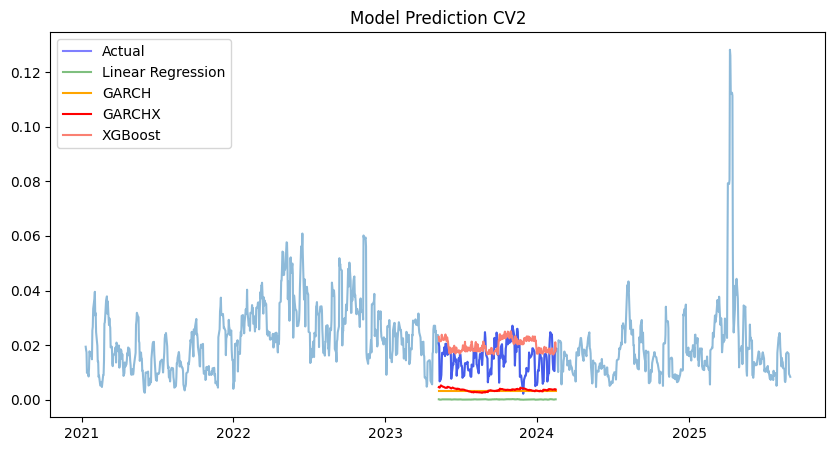

In [ ]:
# GARCHX Prediction for Timeseries CV2
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(y.index), y.values, alpha=0.5) #plotting the entire y data
plt.plot(pd.to_datetime(garchx_y_test_dict.get(2).index), garchx_y_test_dict.get(2)/100, color='blue', label='Actual', alpha=0.5)
plt.plot(pd.to_datetime(lr_tests_dict.get(2).index), lr_tests_dict.get(2)/100, color='green', label='Linear Regression', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(2).index), np.array(garch_y_pred_dict.get(2))/100, color='orange', label="GARCH")
plt.plot(pd.to_datetime(garchx_y_test_dict.get(2).index), np.array(garchx_y_pred_dict.get(2))/100, color='red', label='GARCHX')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(2).index), np.array(xgb_y_pred_dict.get(2)), color='salmon', label='XGBoost')
plt.title("Model Prediction CV2")
plt.legend()
plt.show()

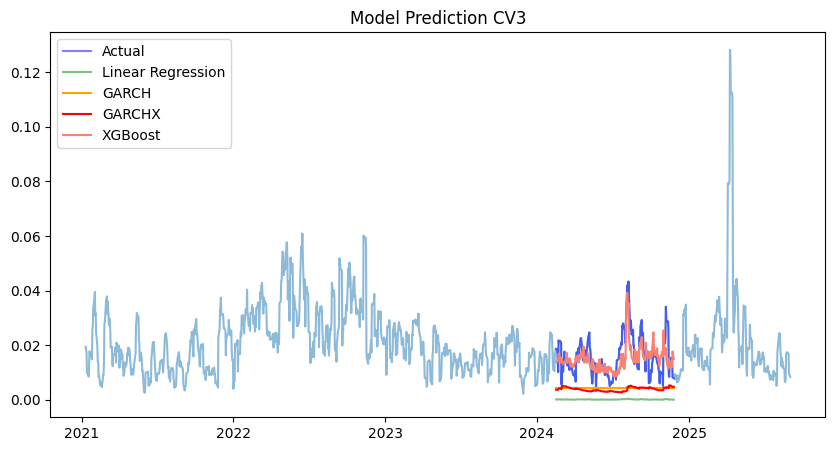

In [ ]:
# GARCHX Prediction for Timeseries CV3
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(y.index), y.values, alpha=0.5) #plotting the entire y data
plt.plot(pd.to_datetime(garchx_y_test_dict.get(3).index), garchx_y_test_dict.get(3)/100, color='blue', label='Actual', alpha=0.5)
plt.plot(pd.to_datetime(lr_tests_dict.get(3).index), lr_tests_dict.get(3)/100, color='green', label='Linear Regression', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(3).index), np.array(garch_y_pred_dict.get(3))/100, color='orange', label="GARCH")
plt.plot(pd.to_datetime(garchx_y_test_dict.get(3).index), np.array(garchx_y_pred_dict.get(3))/100, color='red', label='GARCHX')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(3).index), np.array(xgb_y_pred_dict.get(3)), color='salmon', label='XGBoost')
plt.title("Model Prediction CV3")
plt.legend()
plt.show()

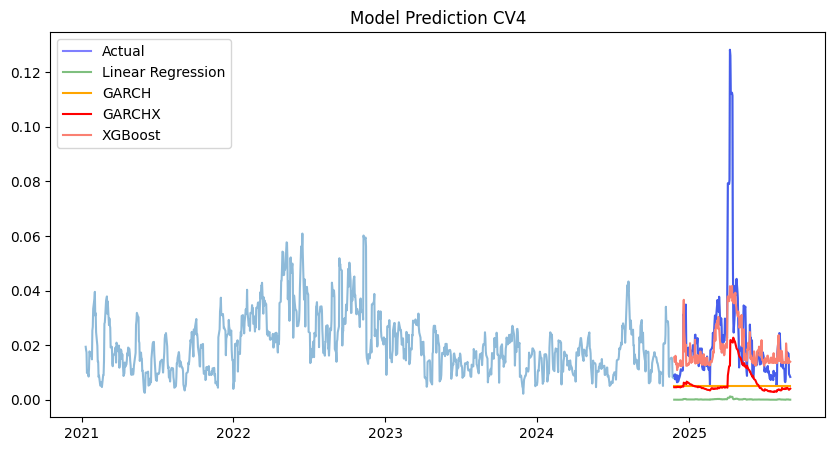

In [ ]:
# GARCHX Prediction for Timeseries CV4
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(y.index), y.values, alpha=0.5) #plotting the entire y data
plt.plot(pd.to_datetime(garchx_y_test_dict.get(4).index), garchx_y_test_dict.get(4)/100, color='blue', label='Actual', alpha=0.5)
plt.plot(pd.to_datetime(lr_tests_dict.get(4).index), lr_tests_dict.get(4)/100, color='green', label='Linear Regression', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(4).index), np.array(garch_y_pred_dict.get(4))/100, color='orange', label="GARCH")
plt.plot(pd.to_datetime(garchx_y_test_dict.get(4).index), np.array(garchx_y_pred_dict.get(4))/100, color='red', label='GARCHX')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(4).index), np.array(xgb_y_pred_dict.get(4)), color='salmon', label='XGBoost')
plt.title("Model Prediction CV4")
plt.legend()
plt.show()

Combined predictions

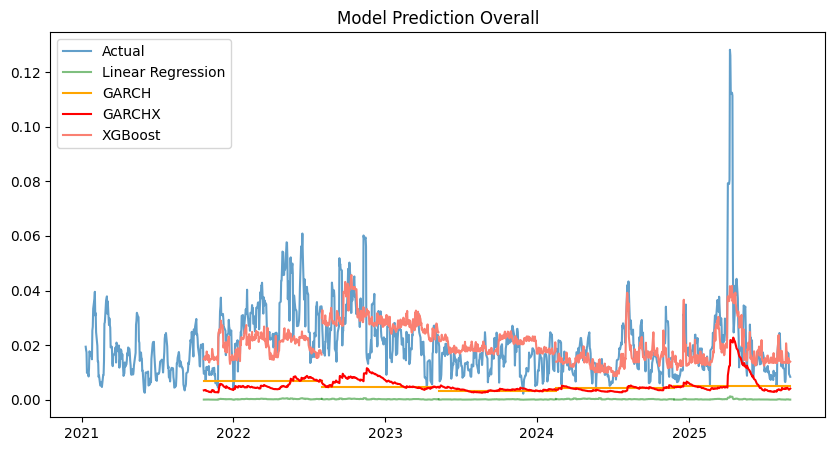

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(y.index), y.values, alpha=0.7, label='Actual') #plotting the entire y data

plt.plot(pd.to_datetime(lr_tests_dict.get(0).index), lr_tests_dict.get(0)/100, color='green', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(0).index), np.array(garch_y_pred_dict.get(0))/100, color='orange')
plt.plot(pd.to_datetime(garchx_y_test_dict.get(0).index), np.array(garchx_y_pred_dict.get(0))/100, color='red')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(0).index), np.array(xgb_y_pred_dict.get(0)), color='salmon')

plt.plot(pd.to_datetime(lr_tests_dict.get(1).index), lr_tests_dict.get(1)/100, color='green', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(1).index), np.array(garch_y_pred_dict.get(1))/100, color='orange')
plt.plot(pd.to_datetime(garchx_y_test_dict.get(1).index), np.array(garchx_y_pred_dict.get(1))/100, color='red')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(1).index), np.array(xgb_y_pred_dict.get(1)), color='salmon')


plt.plot(pd.to_datetime(lr_tests_dict.get(2).index), lr_tests_dict.get(2)/100, color='green', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(2).index), np.array(garch_y_pred_dict.get(2))/100, color='orange')
plt.plot(pd.to_datetime(garchx_y_test_dict.get(2).index), np.array(garchx_y_pred_dict.get(2))/100, color='red')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(2).index), np.array(xgb_y_pred_dict.get(2)), color='salmon')


plt.plot(pd.to_datetime(lr_tests_dict.get(3).index), lr_tests_dict.get(1)/100, color='green', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(3).index), np.array(garch_y_pred_dict.get(3))/100, color='orange')
plt.plot(pd.to_datetime(garchx_y_test_dict.get(3).index), np.array(garchx_y_pred_dict.get(3))/100, color='red')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(3).index), np.array(xgb_y_pred_dict.get(3)), color='salmon')

plt.plot(pd.to_datetime(lr_tests_dict.get(4).index), lr_tests_dict.get(4)/100, color='green', label='Linear Regression', alpha=0.5)
plt.plot(pd.to_datetime(garch_y_test_dict.get(4).index), np.array(garch_y_pred_dict.get(4))/100, color='orange', label="GARCH")
plt.plot(pd.to_datetime(garchx_y_test_dict.get(4).index), np.array(garchx_y_pred_dict.get(4))/100, color='red', label='GARCHX')
plt.plot(pd.to_datetime(xgb_y_test_dict.get(4).index), np.array(xgb_y_pred_dict.get(4)), color='salmon', label='XGBoost')

plt.title("Model Prediction Overall")
plt.legend()
plt.show()